## Libs

In [2]:
!pip install dagshub
!pip install mlflow
!pip install pydantic==1.10.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 21.6 MB/s eta

In [3]:
import dagshub
import mlflow

import os
import PIL

import pandas as pd
import numpy as np
import pickle
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#enter you path to the chapter drive shortcut
root_path = '/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/'

In [6]:
#  input your user id from dagshub
#your_dagshub_user = 'your_dagshub_username'
your_dagshub_user = 'lucasvascrocha'

## Functions

In [88]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, classification_report

def evaluate_classification_multi(y_true, y_pred):
    """Evaluates a classification model by calculating and printing various metrics.

    Args:
        y_true (array): True class values.
        y_pred (_type_): Predicted class values.

    Returns:
        dictionary: Dictionary containing various evaluation metrics including Accuracy, F1 Score, Recall, Confusion Matrix.
    """
    #classes = ['Cescospora','Healthy','Miner','Phoma','Rust']
    #classes = ['Miner','Phoma','Rust']
    classes = ['Healthy','Miner','Phoma','Rust']

    # 1 - Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # 2 - Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # 3 - F1 Score
    f1 = f1_score(y_true, y_pred, average='macro')

    # 4 - Recall for each class
    recall_each_class = recall_score(y_true, y_pred, average=None)
    recall_dict = {classes[i]: recall for i, recall in enumerate(recall_each_class)}

    # 5 - Print Classification Report
    print(classification_report(y_true, y_pred))

    metrics = {
        'Accuracy': round(accuracy,2),
        'F1 Score macro': round(f1,2),
        #'Cescospora Recall': round(recall_dict['Cescospora'],2),
        'Healthy Recall': round(recall_dict['Healthy'],2),
        'Miner Recall': round(recall_dict['Miner'],2),
        'Phoma Recall': round(recall_dict['Phoma'],2),
        'Rust Recall': round(recall_dict['Rust'],2),
        'Confusion Matrix': conf_matrix
    }

    return metrics


In [89]:
def mlflow_track(experiment_name, metrics,model,X,strategy,preprocess,split,obs,loss,metrics_optmizer,learning_rate,train_batch,val_batch):
    """Tracks machine learning experiments using MLflow, including tagging and logging various parameters and metrics.

    Args:
        experiment_name (str): Name of the experiment for grouping and filtering purposes.
        metrics (dict): Dictionary containing evaluation metrics, such as ROC AUC, F1 Score, Recall, TP Rate, FP Rate, etc.
        model (str): Model used in the experiment.
        X (DataFrame): DataFrame containing the features used in the model.
        strategy (str): Strategy employed in the experiment.
        preprocess (str): Preprocessing technique used.
        split (str): Description of the data splitting strategy.
        threshold_defined (float): Manually defined threshold used in predictions.
        obs (str): Any additional observations or notes related to the experiment.

    Note:
        The function uses MLflow to set up an experiment with the given name, tags the experiment with the specified parameters,
        and logs metrics for the experiment. It also ends the current MLflow run after logging, so each call to this function
        should correspond to a distinct experiment run.

    """

    #label para filtrar os experimentos
    mlflow.set_experiment(experiment_name=experiment_name)

    #tags para organizar os experimentos
    #para cada experimento novo eu altero os parâmetros para armazenar as métricas de cada configuração e combinação de exeprimento
    tags = {
            "model": model,
            "strategy":strategy,
            "features": X,
            "preprocess":preprocess,
            "split":split,
            'obs':obs
        }


    #salvando métricas no experimento setado acima
    mlflow.set_tags(tags)

    #para cada experimento novo eu altero os parâmetros para armazenar as métricas de cada configuração e combinação de exeprimento
    # mlflow.log_param("random_state", random_state)
    mlflow.log_param("loss", loss)
    mlflow.log_param("metrics_optmizer", metrics_optmizer)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("train_batch", train_batch)
    mlflow.log_param("val_batch", val_batch)


    mlflow.log_metric("Accuracy", metrics['Accuracy'])
    mlflow.log_metric("F1 Score macro", metrics['F1 Score macro'])
    #mlflow.log_metric("Cescospora Recall", metrics['Cescospora Recall'])
    mlflow.log_metric("Healthy Recall", metrics['Healthy Recall'])
    mlflow.log_metric("Miner Recall", metrics['Miner Recall'])
    mlflow.log_metric("Phoma Recall", metrics['Phoma Recall'])
    mlflow.log_metric("Rust Recall", metrics['Rust Recall'])

    #para fechar a conexão anterior, sempre fechar a conexão depois de iniciar cada experimento
    mlflow.end_run()

## Read data strategy 002

In [90]:
#folders = ['Cescospora','Healthy','Miner','Phoma','Rust']
folders = ['Healthy','Miner','Phoma','Rust']
#folders = ['Miner','Phoma','Rust']

In [91]:
# Inicialize uma lista para armazenar as informações
data = []

for i in range(len(folders)):
  # specific path to strategy
  #path_to_file = f'Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/{folders[i]}'
  path_to_file = f'Task-2-Data Collection & Pre-processing/data/approach_1/02_prepared_train_dataset/002_strategy_just_single_leaves/train_deduplicated/{folders[i]}'

  # all files
  files = os.listdir(root_path + path_to_file)


  for file in files:
    data.append({'target': folders[i], 'file_name': file, 'file_path': root_path + path_to_file + '/' + file})

# dataframe create
df_train = pd.DataFrame(data)


In [92]:
df_train

target                                          file_name  \
0     Healthy  IMG_20230320_120806-432x768_jpg.rf.8617da2ab5a...   
1     Healthy  IMG_20230320_121630-1365x768_jpg.rf.14d9536cf8...   
2     Healthy  IMG_20221126_114045-576x768_jpg.rf.f3a054b2153...   
3     Healthy  IMG_20221126_111924-576x768_jpg.rf.16f80c9c647...   
4     Healthy  IMG_20230320_121937-432x768_jpg.rf.06ea3e1b17c...   
...       ...                                                ...   
3453     Rust                                        C8P34E1.jpg   
3454     Rust                                        C8P35E1.jpg   
3455     Rust                                        C8P37E2.jpg   
3456     Rust                                        C8P35H1.jpg   
3457     Rust                                        C8P38H1.jpg   

                                              file_path  
0     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
2     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
3     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
4     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
...                                                 ...  
3453  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
3454  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
3455  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
3456  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
3457  /content/drive/MyDrive/SaoPauloChapter_Plants-...  

[3458 rows x 3 columns]

In [93]:
df_train['file_path'].iloc[0]

'/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-2-Data Collection & Pre-processing/data/approach_1/02_prepared_train_dataset/002_strategy_just_single_leaves/train_deduplicated/Healthy/IMG_20230320_120806-432x768_jpg.rf.8617da2ab5ae6d49a2f6b7bb5910d425.jpg'

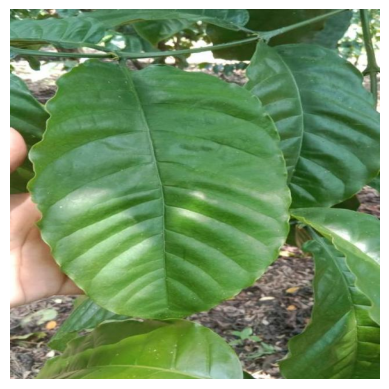

In [94]:
img = PIL.Image.open(df_train['file_path'].iloc[0])

plt.imshow(img)
plt.axis('off')
plt.show()

## Read test and val data

In [95]:
# Inicialize uma lista para armazenar as informações
data = []

for i in range(len(folders)):
  # specific file path
  path_to_file = f'Task-4-Model(s) Building/data/000_test_and_val_dataset_resampled/{folders[i]}'

  # all files
  files = os.listdir(root_path + path_to_file)

  for file in files:
    data.append({'target': folders[i], 'file_name': file, 'file_path': root_path + path_to_file + '/' + file})

# dataframe create
df_val_test = pd.DataFrame(data)



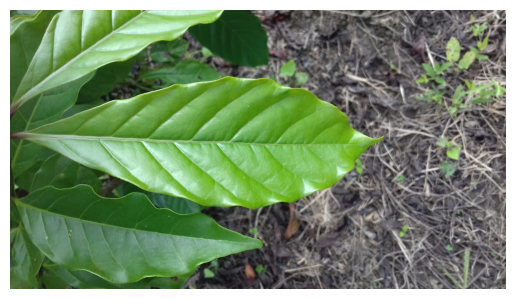

In [96]:
img = PIL.Image.open(df_val_test['file_path'].iloc[0])

plt.imshow(img)
plt.axis('off')
plt.show()

In [97]:
df_val_test

target                                         file_name  \
0     Healthy                                        C1P2H1.jpg   
1     Healthy                                        C1P1H1.jpg   
2     Healthy                                        C1P3H1.jpg   
3     Healthy                                        C1P4H1.jpg   
4     Healthy                                        C1P3E1.jpg   
...       ...                                               ...   
2183     Rust   769_jpg.rf.95cca684033c0f8bc3613fadf84a4561.jpg   
2184     Rust  1729_jpg.rf.e607bcf04997257fb97d92a9f7fe1ea5.jpg   
2185     Rust  1706_jpg.rf.ded1425fe21145b4441951345998408f.jpg   
2186     Rust   140_jpg.rf.de16ed5b1da47150a394d990fd5860cb.jpg   
2187     Rust   543_jpg.rf.e193bced266f6cd89166ed3bd3b7fd74.jpg   

                                              file_path  
0     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
2     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
3     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
4     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
...                                                 ...  
2183  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
2184  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
2185  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
2186  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
2187  /content/drive/MyDrive/SaoPauloChapter_Plants-...  

[2188 rows x 3 columns]

In [98]:
df_val_test['target'].unique()

array(['Healthy', 'Miner', 'Phoma', 'Rust'], dtype=object)

## Separate val and test


In [99]:
# split data keeping the same quantity of each label in each dataset
df_val, df_test = train_test_split(df_val_test, test_size=0.5, stratify=df_val_test['target'], random_state=42)


In [100]:
df_val.groupby('target').count()

file_name  file_path
target                       
Healthy        395        395
Miner          185        185
Phoma           53         53
Rust           461        461

In [101]:
df_test.groupby('target').count()

file_name  file_path
target                       
Healthy        396        396
Miner          184        184
Phoma           54         54
Rust           460        460

## Mixing val dataset into the train dataset

In [102]:
df_train

target                                          file_name  \
0     Healthy  IMG_20230320_120806-432x768_jpg.rf.8617da2ab5a...   
1     Healthy  IMG_20230320_121630-1365x768_jpg.rf.14d9536cf8...   
2     Healthy  IMG_20221126_114045-576x768_jpg.rf.f3a054b2153...   
3     Healthy  IMG_20221126_111924-576x768_jpg.rf.16f80c9c647...   
4     Healthy  IMG_20230320_121937-432x768_jpg.rf.06ea3e1b17c...   
...       ...                                                ...   
3453     Rust                                        C8P34E1.jpg   
3454     Rust                                        C8P35E1.jpg   
3455     Rust                                        C8P37E2.jpg   
3456     Rust                                        C8P35H1.jpg   
3457     Rust                                        C8P38H1.jpg   

                                              file_path  
0     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
2     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
3     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
4     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
...                                                 ...  
3453  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
3454  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
3455  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
3456  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
3457  /content/drive/MyDrive/SaoPauloChapter_Plants-...  

[3458 rows x 3 columns]

In [103]:
df_val

target                                         file_name  \
1051    Miner   433_jpg.rf.f2bcb67aa3b83cfc0cb67519425e902f.jpg   
978     Miner                               bicho_mineiro35.jpg   
1205    Phoma   227_jpg.rf.5c4f30e4f30af5c1ec4ba054dbfc3485.jpg   
1422     Rust                                       name257.jpg   
1822     Rust  1485_jpg.rf.ca47ec1280744d7573a4226a1243f6f1.jpg   
...       ...                                               ...   
1400     Rust                                       name240.jpg   
1741     Rust  1349_jpg.rf.0867e46d2ee8d91e3a370e903d3a389b.jpg   
1687     Rust  1112_jpg.rf.0b9169ba38ffacc5c3c5afaca27feb99.jpg   
2     Healthy                                        C1P3H1.jpg   
1223    Phoma  1607_jpg.rf.fb7013ed0c65dca8919cd49ffe7c6171.jpg   

                                              file_path  
1051  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
978   /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1205  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1422  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1822  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
...                                                 ...  
1400  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1741  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1687  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
2     /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1223  /content/drive/MyDrive/SaoPauloChapter_Plants-...  

[1094 rows x 3 columns]

In [104]:
df_train_and_val = pd.concat([df_train, df_test])

In [105]:
df_train, df_val = train_test_split(df_train_and_val, test_size=0.3, stratify=df_train_and_val['target'], random_state=42)

In [106]:
df_train.shape

(3186, 3)

In [107]:
df_val.shape

(1366, 3)

## Modeling

### MobileNetv2 copy

In [ ]:
def saveImageDataAndMetaData(dataDir, outputDir, classNames):
    metadata_tuplelist = []
    if classNames != None:
      class_list = [x for x in dataDir.iterdir() if x.name in classNames]
    else:
      class_list = [x for x in dataDir.iterdir()]
    for c, class_ in enumerate(class_list):
        print(f"Tracking {class_}")
        for f, file in enumerate(class_.glob(f"*")):
            im = cv2.imread(str(file))
            h, w, ch = im.shape
            metadata_tuplelist.append((f"{file}", class_.name, h, w, ch))
    print(len(metadata_tuplelist))
    metadata_df = pd.DataFrame(metadata_tuplelist, columns=['FileName', 'ClassName', 'FrameHeight', 'FrameWidth', 'Channels'])
    print(metadata_df.shape)
    metadata_df.to_csv(outputDir.joinpath("coffeediseasedata.csv"))

In [ ]:
def generate_pie_plot(df, title="Categories", ax = None):
    proportions = []
    sz = len(df.Disease.unique())
    total = np.sum(df.numberImages)
    for c in range(sz):
        prop = df.numberImages[c]
        print(f"Proportion of data in class {df.Disease[c]} is {prop} : {prop/total*100:0.2f} %")
        proportions.append(prop)

    #colors = ['#003f5c', '#58508d' , '#bc5090', '#ff6361', '#ffa600']
    colors = ['gray', '#f8af3a', '#544ED5', '#71a2a5', '#bc5090']

    if ax is None:
        fig, ax = plt.subplots()
    ax.pie(proportions, labels=df.Disease, autopct='%1.1f%%', colors = colors, textprops={'color':"black"})
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax.set_title(title, color='black')

In [ ]:
def VisualizeSampleImages(image, convert=False):
    ## Note convert from BGR to RGB here
    if convert:
      plt.imshow(image[:,:,::-1])
    else:
      plt.imshow(image)
    #plt.show()

In [ ]:
from pathlib import Path

In [ ]:
root_dir = '/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/'

In [ ]:
SINGLE_LEAVES_DATA_DIR = Path(root_dir).joinpath('Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train')

In [ ]:
CLASSNAMES = ['Healthy', 'Cescospora', 'Miner', 'Phoma', 'Rust']

In [ ]:
saveImageDataAndMetaData(SINGLE_LEAVES_DATA_DIR, SINGLE_LEAVES_DATA_DIR, CLASSNAMES)

Tracking /content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Phoma
Tracking /content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Miner
Tracking /content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Cescospora
Tracking /content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Healthy
Tracking /content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Rust
4444
(4444, 5)


In [ ]:
IMAGE_SIZE = 256
META_DATA_FILE = SINGLE_LEAVES_DATA_DIR / 'coffeediseasedata.csv'
batch_size = 32

In [ ]:
coffee_images, coffee_classes, coffee_ids = LoadData(SINGLE_LEAVES_DATA_DIR, IMAGE_SIZE)

4444


In [ ]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_id, val_id, train_class, test_class = \
train_test_split(coffee_images, coffee_ids, coffee_classes,
                 test_size=0.1, random_state=1234, shuffle=True, stratify=coffee_classes)

In [ ]:
train_df = pd.DataFrame(np.array(np.unique(train_class, return_counts=True)).T, columns=['Disease', 'numberImages'])
test_df = pd.DataFrame(np.array(np.unique(test_class, return_counts=True)).T, columns=['Disease', 'numberImages'])
train_df['numberImages'] = train_df['numberImages'].astype('int32')
test_df['numberImages'] = test_df['numberImages'].astype('int32')

Proportion of data in class Cescospora is 180 : 4.50 %
Proportion of data in class Healthy is 664 : 16.60 %
Proportion of data in class Miner is 908 : 22.71 %
Proportion of data in class Phoma is 743 : 18.58 %
Proportion of data in class Rust is 1504 : 37.61 %
Proportion of data in class Cescospora is 20 : 4.49 %
Proportion of data in class Healthy is 74 : 16.63 %
Proportion of data in class Miner is 101 : 22.70 %
Proportion of data in class Phoma is 83 : 18.65 %
Proportion of data in class Rust is 167 : 37.53 %


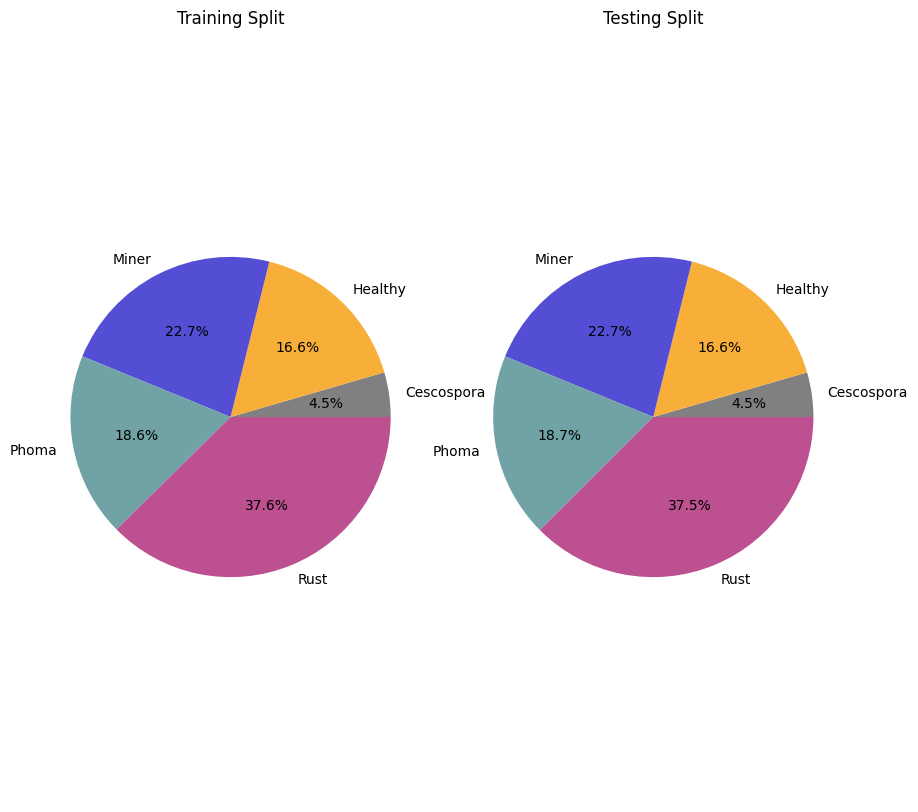

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
generate_pie_plot(train_df, title="Training Split", ax=ax[0])
generate_pie_plot(test_df, title="Testing Split", ax=ax[1])

In [ ]:
import tensorflow as tf

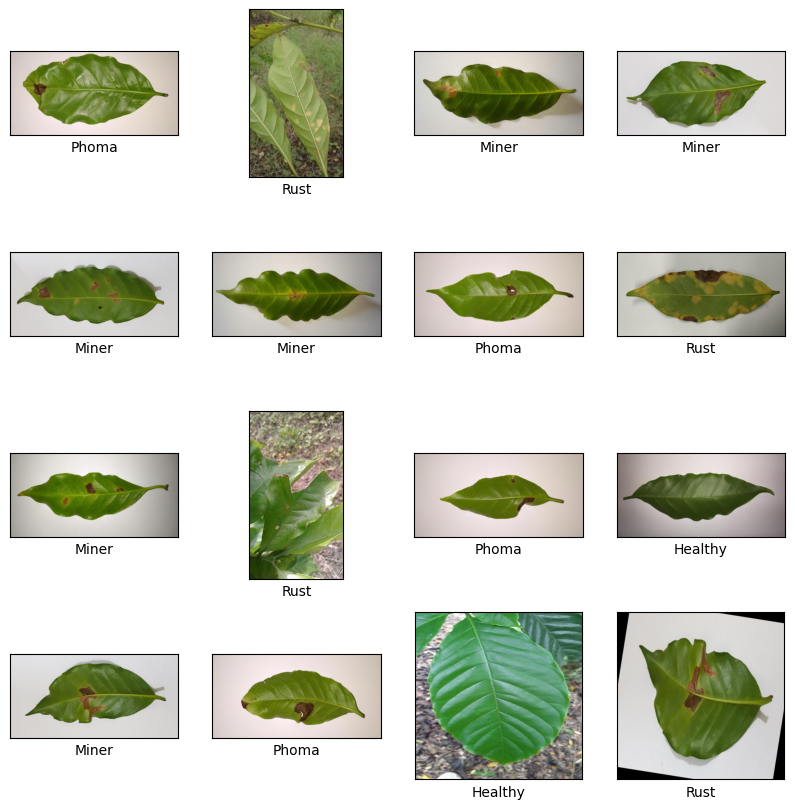

In [ ]:
plt.subplots(4, 4, figsize=(10,10))
num_total = coffee_images.shape[0]
for i, k in enumerate(np.random.randint(num_total, size=16)):
    image = cv2.imread(coffee_images[k])
    plt.subplot(4, 4, i+1)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(image, True)
    plt.xlabel(coffee_classes[k])

In [ ]:
train_ds = tf.data.Dataset.list_files(train_images.tolist(), shuffle=False)
train_ds = train_ds.shuffle(train_df.numberImages.sum(), reshuffle_each_iteration=False)

In [ ]:
val_ds = tf.data.Dataset.list_files(val_images.tolist(), shuffle=False)

In [ ]:
for f in train_ds.take(5):
  print(f.numpy())

b'/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Rust/cld-kaggle-train-rust (260).jpg'
b'/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Miner/1360_jpg.rf.ccd02dad7fd8c65b1c870edbca592bd1.jpg'
b'/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Phoma/233.jpg'
b'/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Miner/cld-kaggle-train-miner (311).jpg'
b'/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Rust/1428_jpg.rf.e9fd2454778eede22068081c95533864.jpg'


In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

3999
445


In [ ]:
## Boilerplate
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == CLASSNAMES
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def configure_for_performance(ds):
  #ds = ds.apply(tf.data.experimental.unbatch())
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
for image, label in train_ds.take(5):
  #print("File name: ", filename.numpy())
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (256, 256, 3)
Label:  4
Image shape:  (256, 256, 3)
Label:  2
Image shape:  (256, 256, 3)
Label:  3
Image shape:  (256, 256, 3)
Label:  2
Image shape:  (256, 256, 3)
Label:  4


In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

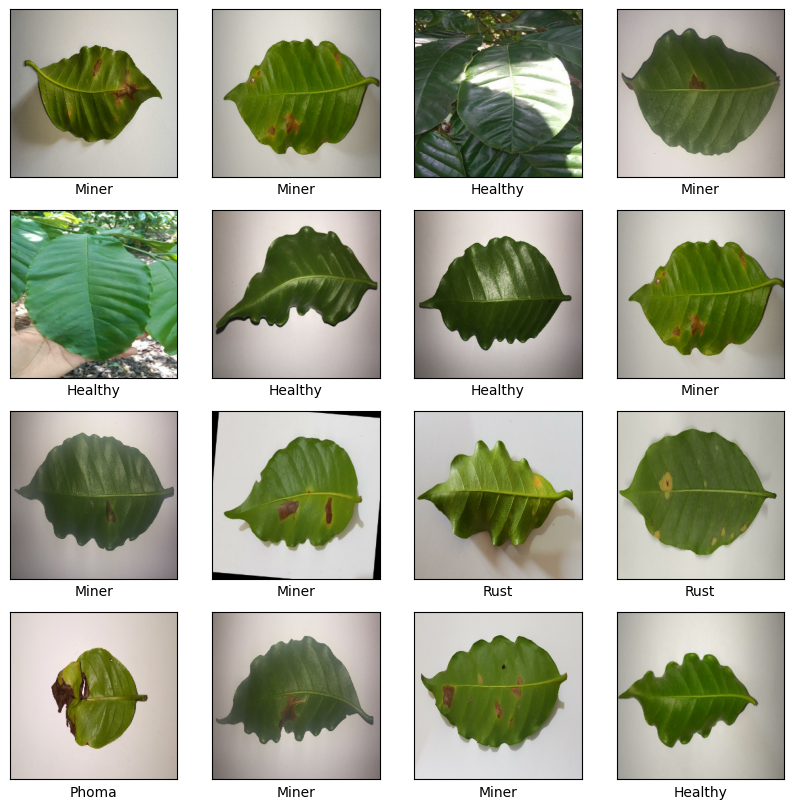

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.subplots(4, 4, figsize=(10,10))
for i, k in enumerate(np.random.randint(batch_size, size=16)):
    plt.subplot(4, 4, i+1)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(image_batch[k].numpy().astype("uint8"))
    plt.xlabel(CLASSNAMES[label_batch[k]])

In [ ]:
# Models
from keras.models import Model
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from keras.layers import Input, Dropout, SeparableConv2D, Dense, Flatten, BatchNormalization

In [ ]:
backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
backbone.trainable = False

In [ ]:
MODEL_NAME = 'Coffee_Disease_Classifier'
#InputLayer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")
# Preprocess Input
x = mobilenet_v2.preprocess_input(inputs)
# MobileNetV2 Backbone
x = backbone(x)
# Regularization
x = Dropout(0.3, name="DropOut")(x)
# FCN
x = Flatten()(x)
x = Dense(1024, activation='relu', name="Dense_FCN_1")(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', name="Dense_FCN_2")(x)
x = Dropout(0.15)(x)
# Outputs
outputs = Dense(5, activation='softmax')(x)
#Model
model_1 = Model(inputs, outputs, name=MODEL_NAME)
model_1.summary()

Model: "Coffee_Disease_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 256, 256, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 256, 256, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 DropOut (Dropout)           (None, 8, 8, 1280)        0         
                                         

In [ ]:
# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
# Optimizer
from tensorflow.keras.optimizers import Adam

In [ ]:
class ShowProgress(Callback):

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            plt.subplots(1, 2, figsize=(10, 10))
            for image, label in train_ds.take(1):
                pred_kps = self.model.predict(image)
                plt.subplot(1, 2, 1)
                plt.gca().set_yticklabels([])
                plt.gca().set_xticklabels([])
                plt.gca().set_xticks([])
                plt.gca().set_yticks([])
                VisualizeSampleImages(image[0].numpy().astype("uint8"))
                plt.xlabel(f"Predicted: {CLASSNAMES[np.argmax(pred_kps, axis=1)[0]]}/ GT: {CLASSNAMES[label[0]]}")
                #plt.xlabel(f"GT:{input_class[k]}")
            plt.show()

In [ ]:
WEIGHT_DIR = Path('/content/drive/MyDrive/CoffeeCheckpoints')
WEIGHT_DIR.mkdir(parents=True, exist_ok=True)

Epoch 1/10
1/1 [==============================] - 1s 844ms/step


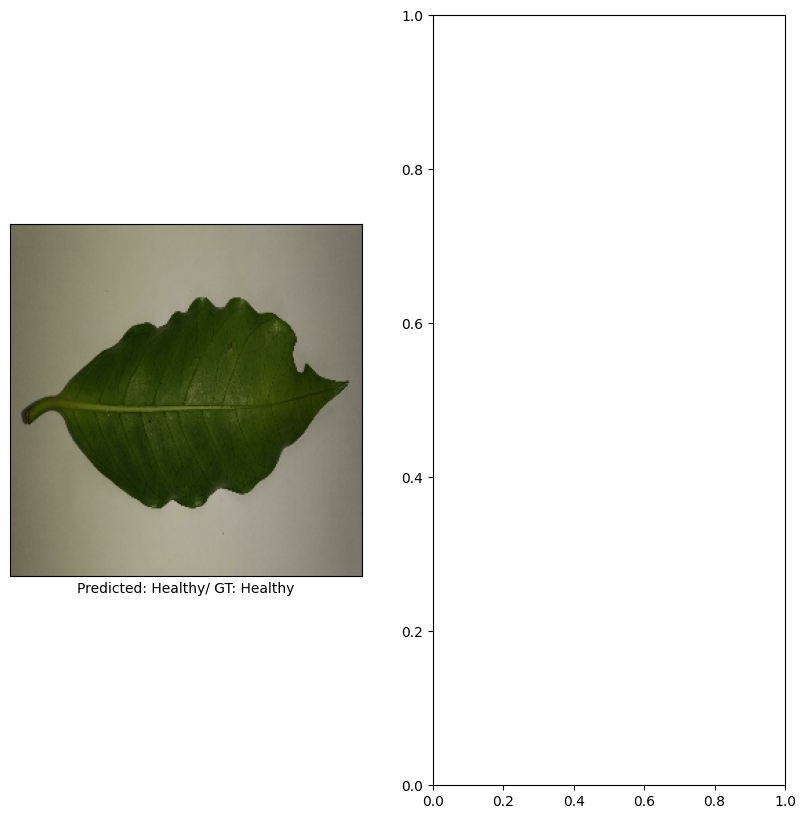

125/125 [==============================] - 105s 658ms/step - loss: 0.8397 - accuracy: 0.7597 - val_loss: 0.3115 - val_accuracy: 0.8831
Epoch 2/10
125/125 [==============================] - 67s 537ms/step - loss: 0.2477 - accuracy: 0.9150 - val_loss: 0.2850 - val_accuracy: 0.8742
Epoch 3/10
125/125 [==============================] - 15s 119ms/step - loss: 0.1481 - accuracy: 0.9522 - val_loss: 0.3030 - val_accuracy: 0.8899
Epoch 4/10
125/125 [==============================] - 14s 114ms/step - loss: 0.0954 - accuracy: 0.9667 - val_loss: 0.2975 - val_accuracy: 0.8944
Epoch 5/10
125/125 [==============================] - 11s 90ms/step - loss: 0.0647 - accuracy: 0.9800 - val_loss: 0.3556 - val_accuracy: 0.8787
Epoch 6/10
125/125 [==============================] - 31s 248ms/step - loss: 0.0462 - accuracy: 0.9872 - val_loss: 0.2665 - val_accuracy: 0.8944
Epoch 7/10
125/125 [==============================] - 12s 96ms/step - loss: 0.0507 - accuracy: 0.9875 - val_loss: 0.3525 - val_accuracy: 0.89

In [ ]:
EPOCHS=10
# Compile
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate=1e-4),
                metrics=['accuracy']) # Lower the Learning Rate better the results.
checkpoint_path = str(WEIGHT_DIR)+MODEL_NAME+"-{epoch:04d}.ckpt"
# Model Training
callbacks = [
#     EarlyStopping(patience=7, restore_best_weights=True), # keep the patience low.
    ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True),
    ShowProgress()
]
weights = {0:(4444/(4*664)), 1:(4444/(4*180)), 2:(4444/(4*908)), 3:(4444/(4*743)), 4:(4444/(4*1504))}
history = model_1.fit(train_ds,
                      validation_data=val_ds,
                      epochs=EPOCHS,
                      steps_per_epoch = 125,
                      class_weight=weights,
                      callbacks=callbacks)

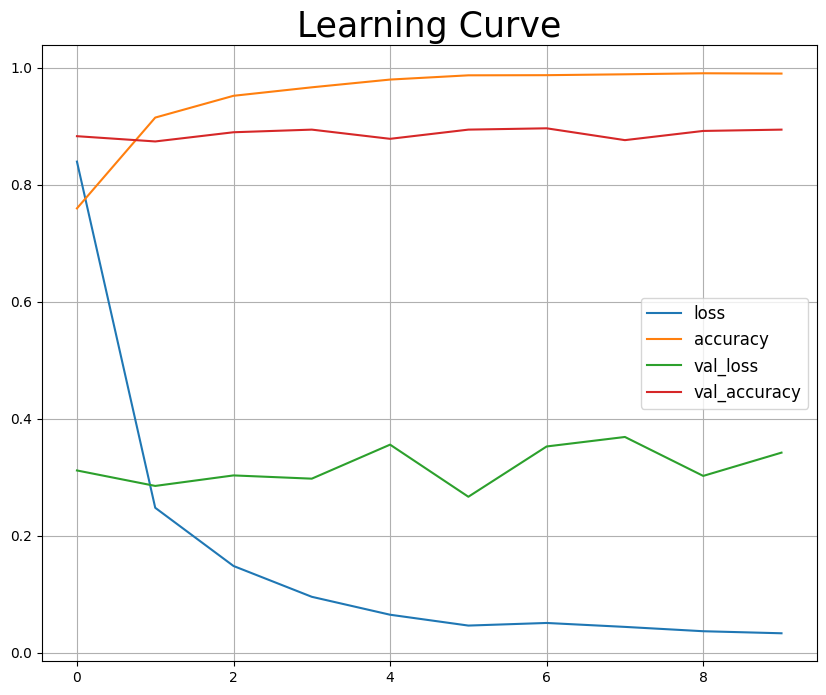

In [ ]:
lc = pd.DataFrame(history.history)
lc.plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=25)
plt.grid()
plt.legend(fontsize=12)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
def Accuracy_ConfusionMatrix(actual, predicted, categories):
    print(f"Accuracy of model: {accuracy_score(actual, predicted)}")
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'])
    print(confusion_matrix)
    print("Sensitivity of model for individual classes")
    class_sum = np.sum(confusion_matrix, axis=1)
    for c,i in enumerate(categories):
        print(f"Class {i} : {confusion_matrix.iloc[c][c]/class_sum[c]}")

In [ ]:
def get_predicted_classes(data_images, model):
    '''
    data_images: shape [None, 112, 112, 3]
    '''
    data_kps = model.predict(data_images)
    return data_kps

In [ ]:
def generateMatrix(dataset):
    ds_labels=[]
    pred_labels=[]
    for images, labels in dataset:
        ds_labels.extend(labels.numpy().tolist()) # or labels.numpy().argmax() for int labels
        precited_train_classes = get_predicted_classes(images, model_1)
        pred_labels.extend(np.argmax(precited_train_classes, axis = 1))
    Accuracy_ConfusionMatrix(ds_labels, pred_labels, CLASSNAMES)
    return ds_labels, pred_labels

In [ ]:
train_true, train_pred = generateMatrix(train_ds)

1/1 [==============================] - 2s 2s/step
Accuracy of model: 0.9949987496874219
Predicted    0    1    2    3     4
Actual                             
0          663    0    0    0     1
1            0  180    0    0     0
2            3    0  904    0     1
3            0    0    0  743     0
4            9    0    6    0  1489
Sensitivity of model for individual classes
Class Healthy : 0.9984939759036144
Class Cescospora : 1.0
Class Miner : 0.9955947136563876
Class Phoma : 1.0
Class Rust : 0.9900265957446809


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(train_true, train_pred, target_names=CLASSNAMES))

              precision    recall  f1-score   support

     Healthy       0.98      1.00      0.99       664
  Cescospora       1.00      1.00      1.00       180
       Miner       0.99      1.00      0.99       908
       Phoma       1.00      1.00      1.00       743
        Rust       1.00      0.99      0.99      1504

    accuracy                           0.99      3999
   macro avg       0.99      1.00      1.00      3999
weighted avg       1.00      0.99      1.00      3999



In [ ]:
val_true, val_pred = generateMatrix(val_ds)

1/1 [==============================] - 0s 33ms/step
Accuracy of model: 0.8943820224719101
Predicted   0   1   2   3    4
Actual                        
0          73   1   0   0    0
1           1  18   0   0    1
2           3   0  87   1   10
3           2   0   3  78    0
4           8   2  14   1  142
Sensitivity of model for individual classes
Class Healthy : 0.9864864864864865
Class Cescospora : 0.9
Class Miner : 0.8613861386138614
Class Phoma : 0.9397590361445783
Class Rust : 0.8502994011976048


In [ ]:
print(classification_report(val_true, val_pred, target_names=CLASSNAMES))

              precision    recall  f1-score   support

     Healthy       0.84      0.99      0.91        74
  Cescospora       0.86      0.90      0.88        20
       Miner       0.84      0.86      0.85       101
       Phoma       0.97      0.94      0.96        83
        Rust       0.93      0.85      0.89       167

    accuracy                           0.89       445
   macro avg       0.89      0.91      0.90       445
weighted avg       0.90      0.89      0.89       445



In [ ]:
test_ds = tf.data.Dataset.list_files(val_images.tolist(), shuffle=False)

### MobileNetv2 changing

In [ ]:
def saveImageDataAndMetaData(dataDir, outputDir, classNames):
    metadata_tuplelist = []
    if classNames != None:
      class_list = [x for x in dataDir.iterdir() if x.name in classNames]
    else:
      class_list = [x for x in dataDir.iterdir()]
    for c, class_ in enumerate(class_list):
        print(f"Tracking {class_}")
        for f, file in enumerate(class_.glob(f"*")):
            im = cv2.imread(str(file))
            h, w, ch = im.shape
            metadata_tuplelist.append((f"{file}", class_.name, h, w, ch))
    print(len(metadata_tuplelist))
    metadata_df = pd.DataFrame(metadata_tuplelist, columns=['FileName', 'ClassName', 'FrameHeight', 'FrameWidth', 'Channels'])
    print(metadata_df.shape)
    metadata_df.to_csv(outputDir.joinpath("coffeediseasedata2.csv"))

In [ ]:
def generate_pie_plot(df, title="Categories", ax = None):
    proportions = []
    sz = len(df.Disease.unique())
    total = np.sum(df.numberImages)
    for c in range(sz):
        prop = df.numberImages[c]
        print(f"Proportion of data in class {df.Disease[c]} is {prop} : {prop/total*100:0.2f} %")
        proportions.append(prop)

    #colors = ['#003f5c', '#58508d' , '#bc5090', '#ff6361', '#ffa600']
    colors = ['gray', '#f8af3a', '#544ED5', '#71a2a5', '#bc5090']

    if ax is None:
        fig, ax = plt.subplots()
    ax.pie(proportions, labels=df.Disease, autopct='%1.1f%%', colors = colors, textprops={'color':"black"})
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax.set_title(title, color='black')

In [ ]:
def VisualizeSampleImages(image, convert=False):
    ## Note convert from BGR to RGB here
    if convert:
      plt.imshow(image[:,:,::-1])
    else:
      plt.imshow(image)
    #plt.show()

In [ ]:
## Load all the images and the keypoints
def LoadData(inputDir, imageSize):
    all_images = []
    all_classes = []
    all_ids = []
    for j, p in enumerate(inputDir.glob(f"*.csv")):
        df = pd.read_csv(p)
        sz = df.shape[0]
        for i in range(sz):
            file = df.iloc[i]['FileName']
            #img = cv2.imread(str(inputDir.joinpath(file)))
            #plt.imshow(img)
            #plt.show()
            all_classes.append(df.iloc[i]['ClassName'])
            #img = cv2.resize(img, (imageSize, imageSize))
            all_images.append(file)
            all_ids.append(file.split('.')[0])
    print(len(all_images))
    all_images = np.asarray(all_images)
    all_classes = np.asarray(all_classes)
    all_ids = np.asarray(all_ids)
    return all_images, all_classes, all_ids

## Load all the images and the keypoints
def LoadData2(inputDir, imageSize):
    all_images = []
    all_classes = []
    all_ids = []
    for j, p in enumerate(inputDir.glob(f"*.csv")):
        df = pd.read_csv(p)
        sz = df.shape[0]
        for i in range(sz):
            file = df.iloc[i]['FileName']
            #img = cv2.imread(str(inputDir.joinpath(file)))
            #plt.imshow(img)
            #plt.show()
            all_classes.append(df.iloc[i]['ClassName'])
            #img = cv2.resize(img, (imageSize, imageSize))
            all_images.append(file)
            all_ids.append(file.split('.')[0])
    print(len(all_images))
    all_images = np.asarray(all_images)
    all_classes = np.asarray(all_classes)
    all_ids = np.asarray(all_ids)
    return all_images, all_classes, all_ids

In [ ]:
from pathlib import Path

In [ ]:
root_dir = '/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/'

In [ ]:
#CLASSNAMES = ['Healthy', 'Cescospora', 'Miner', 'Phoma', 'Rust']
CLASSNAMES = ['Miner', 'Phoma', 'Rust']

In [ ]:
SINGLE_LEAVES_DATA_DIR = Path(root_dir).joinpath('Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train')


In [ ]:
#saveImageDataAndMetaData(SINGLE_LEAVES_DATA_DIR, SINGLE_LEAVES_DATA_DIR, CLASSNAMES)

In [ ]:
IMAGE_SIZE = 256
META_DATA_FILE = SINGLE_LEAVES_DATA_DIR / 'coffeediseasedata.csv'
batch_size = 32

In [ ]:
coffee_images, coffee_classes, coffee_ids = LoadData(SINGLE_LEAVES_DATA_DIR, IMAGE_SIZE)

4444


In [ ]:
#val
SINGLE_LEAVES_DATA_DIR_VAL = Path(root_dir).joinpath('Task-4-Model(s) Building/data/000_test_and_val_dataset_resampled')


In [ ]:
#saveImageDataAndMetaData(SINGLE_LEAVES_DATA_DIR, SINGLE_LEAVES_DATA_DIR, CLASSNAMES)

In [ ]:
IMAGE_SIZE = 256
META_DATA_FILE_VAL = SINGLE_LEAVES_DATA_DIR_VAL / 'coffeediseasedata.csv'
batch_size = 32

In [ ]:
META_DATA_FILE

PosixPath('/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/coffeediseasedata.csv')

In [ ]:
val_coffee_images, val_coffee_classes, val_coffee_ids = LoadData2(SINGLE_LEAVES_DATA_DIR_VAL, IMAGE_SIZE)

2300


In [ ]:
from sklearn.model_selection import train_test_split
test_images, val_images, test_id, val_id, test_class, val_class = \
train_test_split(val_coffee_images, val_coffee_ids, val_coffee_classes,
                 test_size=0.5, random_state=1234, shuffle=True, stratify=val_coffee_classes)

In [ ]:
#train
train_images = coffee_images
train_id = coffee_ids
train_class = coffee_classes

#val
val_images = val_images
val_id = val_id
val_class = val_class

#test
test_images = test_images
test_id = test_id
test_class = test_class

In [ ]:
train_df = pd.DataFrame(np.array(np.unique(train_class, return_counts=True)).T, columns=['Disease', 'numberImages'])
val_df = pd.DataFrame(np.array(np.unique(val_class, return_counts=True)).T, columns=['Disease', 'numberImages'])
train_df['numberImages'] = train_df['numberImages'].astype('int32')
val_df['numberImages'] = val_df['numberImages'].astype('int32')

In [ ]:
test_df = pd.DataFrame(np.array(np.unique(test_class, return_counts=True)).T, columns=['Disease', 'numberImages'])
test_df['numberImages'] = test_df['numberImages'].astype('int32')

Proportion of data in class Cescospora is 200 : 4.50 %
Proportion of data in class Healthy is 738 : 16.61 %
Proportion of data in class Miner is 1009 : 22.70 %
Proportion of data in class Phoma is 826 : 18.59 %
Proportion of data in class Rust is 1671 : 37.60 %
Proportion of data in class Cescospora is 56 : 4.87 %
Proportion of data in class Healthy is 395 : 34.35 %
Proportion of data in class Miner is 184 : 16.00 %
Proportion of data in class Phoma is 54 : 4.70 %
Proportion of data in class Rust is 461 : 40.09 %


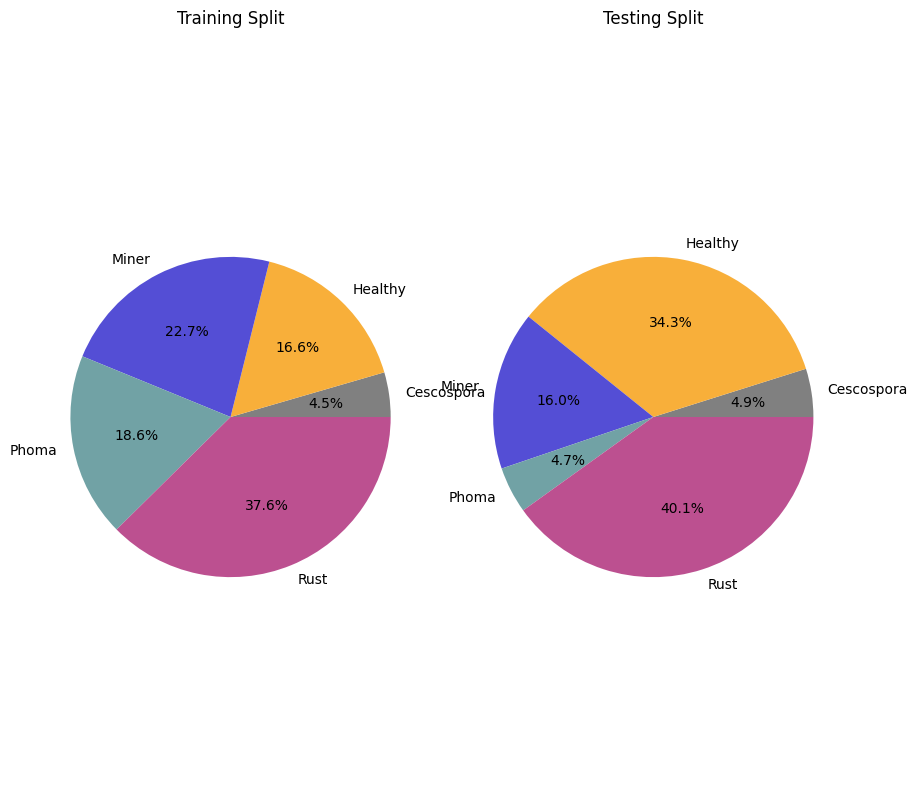

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
generate_pie_plot(train_df, title="Training Split", ax=ax[0])
generate_pie_plot(val_df, title="Testing Split", ax=ax[1])

In [ ]:
import tensorflow as tf

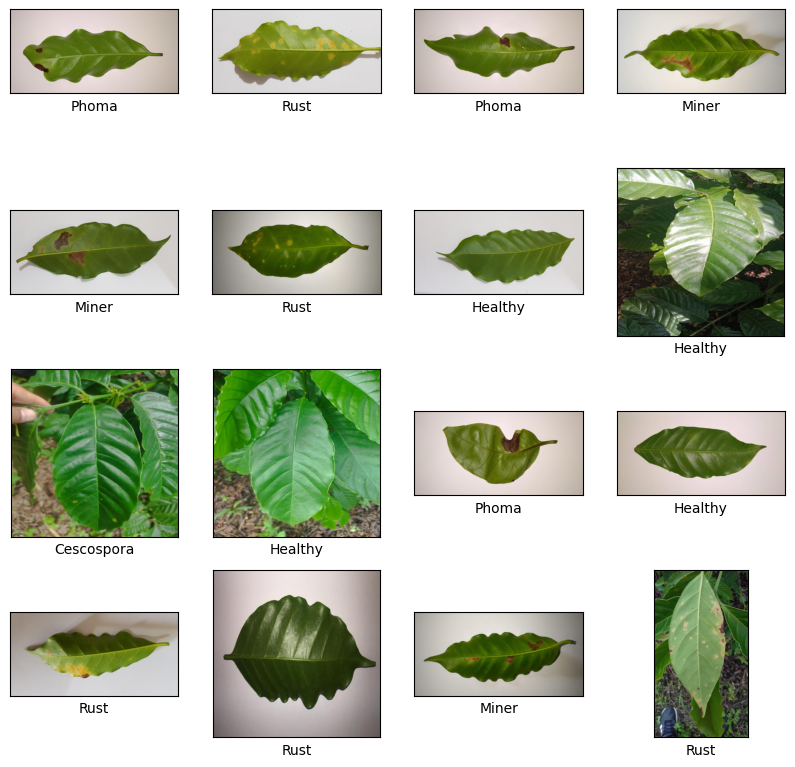

In [ ]:
plt.subplots(4, 4, figsize=(10,10))
num_total = coffee_images.shape[0]
for i, k in enumerate(np.random.randint(num_total, size=16)):
    image = cv2.imread(coffee_images[k])
    plt.subplot(4, 4, i+1)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(image, True)
    plt.xlabel(coffee_classes[k])

In [ ]:
train_ds = tf.data.Dataset.list_files(train_images.tolist(), shuffle=False)
train_ds = train_ds.shuffle(train_df.numberImages.sum(), reshuffle_each_iteration=False)

In [ ]:
val_ds = tf.data.Dataset.list_files(val_images.tolist(), shuffle=False)

In [ ]:
test_ds = tf.data.Dataset.list_files(test_images.tolist(), shuffle=False)

In [ ]:
for f in train_ds.take(5):
  print(f.numpy())

b'/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Healthy/cld-kaggle-train-healthy (178).jpg'
b'/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Rust/1600.jpg'
b'/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Miner/cld-kaggle-train-miner (101).jpg'
b'/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Miner/215.jpg'
b'/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Healthy/IMG_20221126_113901-576x768_jpg.rf.533285bc09851ed3c8b000a01f11e49c.jpg'


In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

4444
1150
1150


In [ ]:
## Boilerplate
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == CLASSNAMES
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def configure_for_performance(ds):
  #ds = ds.apply(tf.data.experimental.unbatch())
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
for image, label in train_ds.take(5):
  #print("File name: ", filename.numpy())
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (256, 256, 3)
Label:  2
Image shape:  (256, 256, 3)
Label:  2
Image shape:  (256, 256, 3)
Label:  2
Image shape:  (256, 256, 3)
Label:  2
Image shape:  (256, 256, 3)
Label:  1


In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

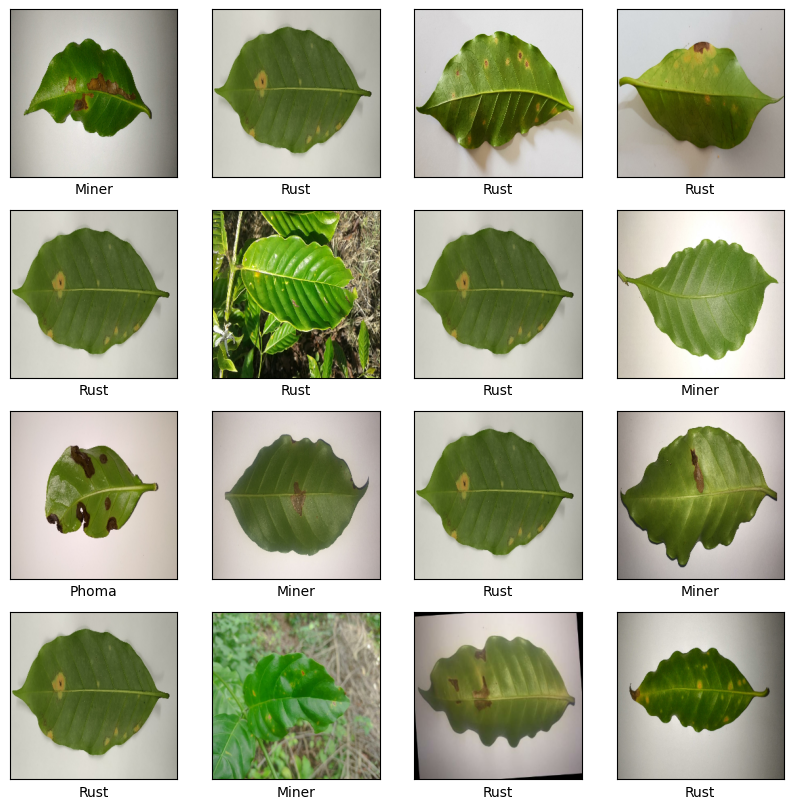

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.subplots(4, 4, figsize=(10,10))
for i, k in enumerate(np.random.randint(batch_size, size=16)):
    plt.subplot(4, 4, i+1)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(image_batch[k].numpy().astype("uint8"))
    plt.xlabel(CLASSNAMES[label_batch[k]])

In [ ]:
# Models
from keras.models import Model
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from keras.layers import Input, Dropout, SeparableConv2D, Dense, Flatten, BatchNormalization

In [ ]:
backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
backbone.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
MODEL_NAME = 'Coffee_Disease_Classifier'
#InputLayer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")
# Preprocess Input
x = mobilenet_v2.preprocess_input(inputs)
# MobileNetV2 Backbone
x = backbone(x)
# Regularization
x = Dropout(0.3, name="DropOut")(x)
# FCN
x = Flatten()(x)
x = Dense(1024, activation='relu', name="Dense_FCN_1")(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', name="Dense_FCN_2")(x)
x = Dropout(0.15)(x)
# Outputs
#outputs = Dense(5, activation='softmax')(x)
outputs = Dense(3, activation='softmax')(x)
#Model
model_1 = Model(inputs, outputs, name=MODEL_NAME)
model_1.summary()

Model: "Coffee_Disease_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 256, 256, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 DropOut (Dropout)           (None, 8, 8, 1280)        0         
                                         

In [ ]:
# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
# Optimizer
from tensorflow.keras.optimizers import Adam

In [ ]:
class ShowProgress(Callback):

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            plt.subplots(1, 2, figsize=(10, 10))
            for image, label in train_ds.take(1):
                pred_kps = self.model.predict(image)
                plt.subplot(1, 2, 1)
                plt.gca().set_yticklabels([])
                plt.gca().set_xticklabels([])
                plt.gca().set_xticks([])
                plt.gca().set_yticks([])
                VisualizeSampleImages(image[0].numpy().astype("uint8"))
                plt.xlabel(f"Predicted: {CLASSNAMES[np.argmax(pred_kps, axis=1)[0]]}/ GT: {CLASSNAMES[label[0]]}")
                #plt.xlabel(f"GT:{input_class[k]}")
            plt.show()

In [ ]:
WEIGHT_DIR = Path('/content/drive/MyDrive/CoffeeCheckpoints')
WEIGHT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
EPOCHS=5
# Compile
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate=1e-4),
                metrics=['accuracy']) # Lower the Learning Rate better the results.
checkpoint_path = str(WEIGHT_DIR)+MODEL_NAME+"-{epoch:04d}.ckpt"
# Model Training
callbacks = [
#     EarlyStopping(patience=7, restore_best_weights=True), # keep the patience low.
    ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True),
    ShowProgress()
]
weights = {0:(4444/(4*664)), 1:(4444/(4*180)), 2:(4444/(4*908)), 3:(4444/(4*743)), 4:(4444/(4*1504))}
history = model_1.fit(train_ds,
                      validation_data=val_ds,
                      epochs=EPOCHS,
                      steps_per_epoch = 125,
                      class_weight=weights,
                      callbacks=callbacks)

Epoch 1/5
125/125 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.9022

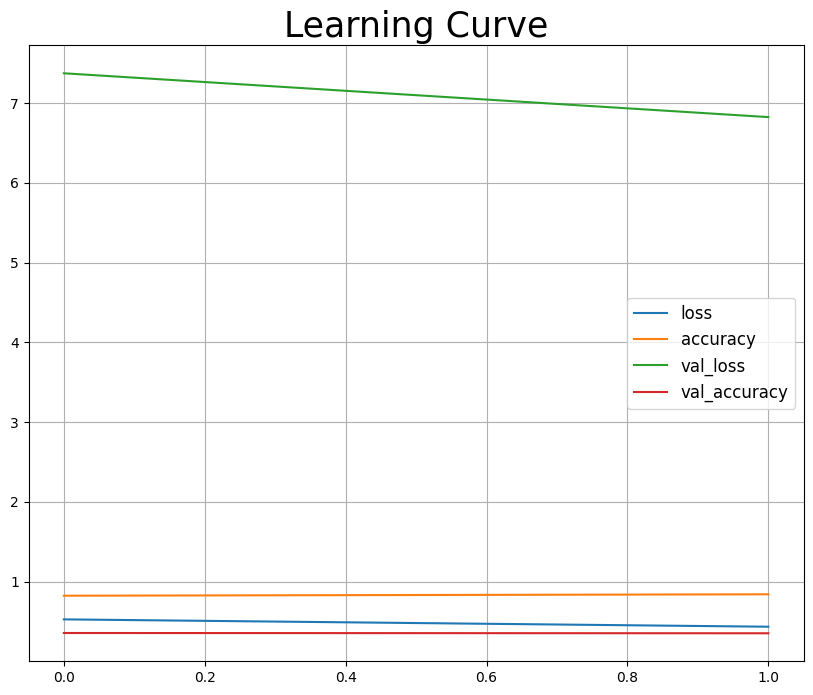

In [ ]:
lc = pd.DataFrame(history.history)
lc.plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=25)
plt.grid()
plt.legend(fontsize=12)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
def Accuracy_ConfusionMatrix(actual, predicted, categories):
    print(f"Accuracy of model: {accuracy_score(actual, predicted)}")
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'])
    print(confusion_matrix)
    print("Sensitivity of model for individual classes")
    class_sum = np.sum(confusion_matrix, axis=1)
    for c,i in enumerate(categories):
        print(f"Class {i} : {confusion_matrix.iloc[c][c]/class_sum[c]}")

In [ ]:
def get_predicted_classes(data_images, model):
    '''
    data_images: shape [None, 112, 112, 3]
    '''
    data_kps = model.predict(data_images)
    return data_kps

In [ ]:
def generateMatrix(dataset):
    ds_labels=[]
    pred_labels=[]
    for images, labels in dataset:
        ds_labels.extend(labels.numpy().tolist()) # or labels.numpy().argmax() for int labels
        precited_train_classes = get_predicted_classes(images, model_1)
        pred_labels.extend(np.argmax(precited_train_classes, axis = 1))
    Accuracy_ConfusionMatrix(ds_labels, pred_labels, CLASSNAMES)
    return ds_labels, pred_labels

In [ ]:
train_true, train_pred = generateMatrix(test_ds)

1/1 [==============================] - 1s 970ms/step
Accuracy of model: 0.35304347826086957
Predicted    0   1    2
Actual                 
0          158  19  460
1           19  17   17
2          133  96  231
Sensitivity of model for individual classes
Class Miner : 0.24803767660910517
Class Phoma : 0.32075471698113206
Class Rust : 0.5021739130434782


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(train_true, train_pred, target_names=CLASSNAMES))

              precision    recall  f1-score   support

       Miner       0.51      0.25      0.33       637
       Phoma       0.13      0.32      0.18        53
        Rust       0.33      0.50      0.40       460

    accuracy                           0.35      1150
   macro avg       0.32      0.36      0.30      1150
weighted avg       0.42      0.35      0.35      1150



In [ ]:
val_true, val_pred = generateMatrix(val_ds)

1/1 [==============================] - 0s 33ms/step
Accuracy of model: 0.8943820224719101
Predicted   0   1   2   3    4
Actual                        
0          73   1   0   0    0
1           1  18   0   0    1
2           3   0  87   1   10
3           2   0   3  78    0
4           8   2  14   1  142
Sensitivity of model for individual classes
Class Healthy : 0.9864864864864865
Class Cescospora : 0.9
Class Miner : 0.8613861386138614
Class Phoma : 0.9397590361445783
Class Rust : 0.8502994011976048


In [ ]:
print(classification_report(val_true, val_pred, target_names=CLASSNAMES))

              precision    recall  f1-score   support

     Healthy       0.84      0.99      0.91        74
  Cescospora       0.86      0.90      0.88        20
       Miner       0.84      0.86      0.85       101
       Phoma       0.97      0.94      0.96        83
        Rust       0.93      0.85      0.89       167

    accuracy                           0.89       445
   macro avg       0.89      0.91      0.90       445
weighted avg       0.90      0.89      0.89       445



In [ ]:
test_ds = tf.data.Dataset.list_files(val_images.tolist(), shuffle=False)

### ResNet50 fine tuned

In [108]:
df_train

target                                         file_name  \
371   Healthy                                       C6P27E2.jpg   
208   Healthy   200_jpg.rf.1a0c1a31c1d053b5a9c789d5a18284b6.jpg   
1406     Rust                                       name237.jpg   
1795    Phoma                                           235.jpg   
2344     Rust                                          1344.jpg   
...       ...                                               ...   
2777     Rust                   cld-kaggle-train-rust (116).jpg   
787     Miner  1073_jpg.rf.7d8877c015fc501269a02939628a8d19.jpg   
1983     Rust   229_jpg.rf.85ab7da52acc34cc595b8d3d0ac5ce1e.jpg   
2054     Rust                                       C9P23E1.jpg   
1454     Rust                                       name286.jpg   

                                              file_path  
371   /content/drive/MyDrive/SaoPauloChapter_Plants-...  
208   /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1406  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1795  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
2344  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
...                                                 ...  
2777  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
787   /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1983  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
2054  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1454  /content/drive/MyDrive/SaoPauloChapter_Plants-...  

[3186 rows x 3 columns]

In [109]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((224, 224))

In [110]:
resnet_model = keras.applications.resnet50.ResNet50(include_top=False,
                                                    input_tensor=tf.keras.Input(shape=(224,224,3))
                                                   )
# resnet_model.summary()

In [111]:
resnet_model.output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [112]:
# convert to Sequential model, omit the last layer
model = keras.models.Sequential()

model.add(resnet_model)

# set trainable=False for all layers
# we don't want to train them again
for layer in model.layers:
    layer.trainable = False

#add a last 1 neuron in last layer
# model.add(layers.Dense(4096))
# model.add(layers.Dense(2048))
# model.add(layers.Dense(1024))
# model.add(layers.Dense(1024))
# model.add(layers.Dense(256))
# model.add(layers.Dense(128))
# model.add(layers.Dense(64))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(1, activation='linear')) # colcoar função de ativção linear

#model.add(layers.Dense(1024))
#model.add(layers.Dense(512))
#model.add(layers.Dense(256))
#model.add(layers.Dense(128))
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(1))

#model.add(layers.Conv2D(2048, (1,1), kernel_regularizer=keras.regularizers.l2(0.01), activation='elu'))
#model.add(layers.Conv2D(2048, (1,1), kernel_regularizer=keras.regularizers.l1(0.01), activation='elu'))


model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2048))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(4096))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2048, activation='relu'))
#model.add(layers.Dense(3, activation='softmax'))
model.add(layers.Dense(4, activation='softmax'))

# model.add(layers.Flatten())
# model.add(layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 2048)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_3 (Dropout)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 2048)              37750784  
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                      

In [113]:
# loss and optimizer
loss = 'categorical_crossentropy'
#optim = keras.optimizers.Adam(learning_rate=0.0000001)
optim = keras.optimizers.Adam(learning_rate=0.00001)
#optim = keras.optimizers.Adam(learning_rate=0.001)
#optim = tf.keras.optimizers.RMSprop(0.00001)
metrics = ['accuracy']

model.compile(optimizer=optim, loss=loss, metrics=metrics)


# get the preprocessing function of this model
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [114]:
# Generate batches of tensor image data with real-time data augmentation.
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                               rescale=1.0/255.0,
#                               rotation_range=360, # Degree range for random rotations
#                               width_shift_range=0.2, # Range for random horizontal shifts
#                               height_shift_range=0.2, # Range for random vertical shifts
#                               zoom_range=0.2, # Range for random zoom
#                               horizontal_flip=True, # Randomly flip inputs horizontally
#                               vertical_flip=True # Randomly flip inputs vertically
)


valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               #rescale=1.0/255.0
)



In [115]:


df_train

target                                         file_name  \
371   Healthy                                       C6P27E2.jpg   
208   Healthy   200_jpg.rf.1a0c1a31c1d053b5a9c789d5a18284b6.jpg   
1406     Rust                                       name237.jpg   
1795    Phoma                                           235.jpg   
2344     Rust                                          1344.jpg   
...       ...                                               ...   
2777     Rust                   cld-kaggle-train-rust (116).jpg   
787     Miner  1073_jpg.rf.7d8877c015fc501269a02939628a8d19.jpg   
1983     Rust   229_jpg.rf.85ab7da52acc34cc595b8d3d0ac5ce1e.jpg   
2054     Rust                                       C9P23E1.jpg   
1454     Rust                                       name286.jpg   

                                              file_path  
371   /content/drive/MyDrive/SaoPauloChapter_Plants-...  
208   /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1406  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1795  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
2344  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
...                                                 ...  
2777  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
787   /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1983  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
2054  /content/drive/MyDrive/SaoPauloChapter_Plants-...  
1454  /content/drive/MyDrive/SaoPauloChapter_Plants-...  

[3186 rows x 3 columns]

In [116]:
train_batches = train_gen.flow_from_dataframe(
    df_train,
    directory= None,
    x_col='file_path',
    y_col='target',
    augment=True,
    target_size=DEFAULT_IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=256,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="jpg",
    subset=None,
    interpolation="nearest" #'bilinear', 'bicubic'
)

val_batches = valid_gen.flow_from_dataframe(
    df_val,
    directory= None,
    x_col='file_path',
    y_col='target',
    target_size=DEFAULT_IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=512,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="jpg",
    subset=None,
    interpolation="nearest"
)

Found 3186 validated image filenames belonging to 4 classes.
Found 1366 validated image filenames belonging to 4 classes.


In [ ]:
epochs = 15

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 1,
    patience=10,
    verbose=1
)

history = model.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=1)

Epoch 1/15
10/10 [==============================] - 790s 79s/step - loss: 3.2303 - accuracy: 0.4902 - val_loss: 1.1658 - val_accuracy: 0.6825
Epoch 2/15
10/10 [==============================] - 77s 8s/step - loss: 1.9115 - accuracy: 0.6358 - val_loss: 1.2136 - val_accuracy: 0.7412
Epoch 3/15
10/10 [==============================] - 75s 8s/step - loss: 1.6373 - accuracy: 0.7000 - val_loss: 1.0476 - val_accuracy: 0.7801
Epoch 4/15
10/10 [==============================] - 90s 9s/step - loss: 1.3777 - accuracy: 0.7224 - val_loss: 0.9966 - val_accuracy: 0.7839
Epoch 5/15
10/10 [==============================] - 75s 8s/step - loss: 1.2681 - accuracy: 0.7533 - val_loss: 1.0396 - val_accuracy: 0.7630
Epoch 6/15
10/10 [==============================] - 75s 8s/step - loss: 1.2489 - accuracy: 0.7358 - val_loss: 1.0178 - val_accuracy: 0.7716
Epoch 7/15
10/10 [==============================] - 90s 9s/step - loss: 1.1520 - accuracy: 0.7402 - val_loss: 0.7978 - val_accuracy: 0.7991
Epoch 8/15
10/10 [

In [ ]:
import time
time.sleep(20000000)

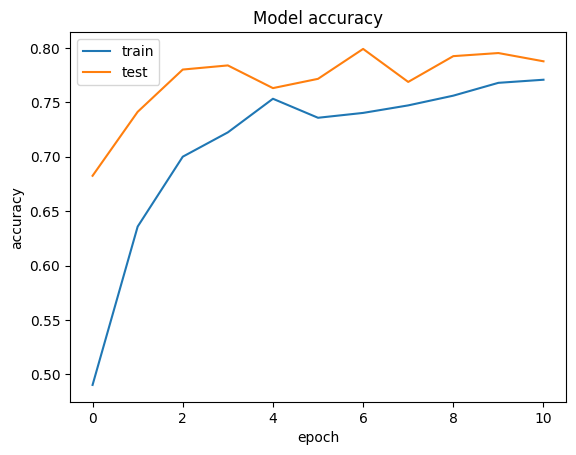

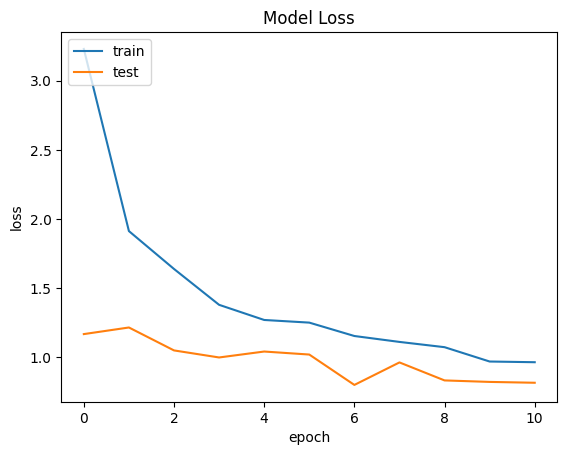

In [ ]:
# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Evaluate predictions in test set

In [117]:
model = load_model('/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-4-Model(s) Building/models/withouth_cersc_resnet50_deduplicated_mix_val_train_75acc.h5')


In [118]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               #rescale=1.0/255.0
)

test_generator  = test_datagen.flow_from_dataframe(
        df_test,
        directory=None,
        x_col="file_path",
        y_col = None,
        target_size=DEFAULT_IMAGE_SIZE,
        color_mode="rgb",
        shuffle = False,
        class_mode=None,
        batch_size=1
        )
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = model.predict_generator(test_generator ,steps = nb_samples)


Found 1094 validated image filenames.


<ipython-input-118-0b97fee1bcdc>:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator ,steps = nb_samples)


In [119]:
predict

array([[8.3145535e-01, 1.4491519e-04, 2.6608951e-04, 1.6813368e-01],
       [9.4565522e-10, 9.9999928e-01, 3.8550749e-09, 7.6242242e-07],
       [9.3625176e-01, 4.1315951e-09, 4.2420393e-07, 6.3747831e-02],
       ...,
       [1.4160247e-05, 3.1648114e-02, 2.0389529e-03, 9.6629870e-01],
       [9.9997437e-01, 2.6056592e-09, 8.7826820e-08, 2.5565952e-05],
       [6.5273731e-08, 2.0003919e-03, 9.9589586e-01, 2.1036668e-03]],
      dtype=float32)

In [120]:
predict[0]*100

array([8.3145538e+01, 1.4491519e-02, 2.6608951e-02, 1.6813368e+01],
      dtype=float32)

In [121]:
predict_percentage = (predict * 100).round(2)
percentages_by_class = pd.DataFrame(predict_percentage, columns=[class_indices[i] for i in range(predict.shape[1])])

In [122]:
percentages_by_class

Healthy   Miner      Phoma       Rust
0      83.150002    0.01   0.030000  16.809999
1       0.000000  100.00   0.000000   0.000000
2      93.629997    0.00   0.000000   6.370000
3      99.970001    0.00   0.000000   0.030000
4       2.680000    0.03   0.000000  97.290001
...          ...     ...        ...        ...
1089    0.000000    0.00  99.959999   0.040000
1090    0.030000    7.28  92.559998   0.130000
1091    0.000000    3.16   0.200000  96.629997
1092  100.000000    0.00   0.000000   0.000000
1093    0.000000    0.20  99.589996   0.210000

[1094 rows x 4 columns]

In [123]:
train_batches.class_indices

{'Healthy': 0, 'Miner': 1, 'Phoma': 2, 'Rust': 3}

In [124]:
#transform predictions in classes
class_indices = train_batches.class_indices
class_indices = {v: k for k, v in class_indices.items()}
predicted_class_indices = np.argmax(predict, axis=1)
predicted_class_names = [class_indices[i] for i in predicted_class_indices]


In [125]:
df_test['predicted'] = predicted_class_names

In [126]:
df_percentages = pd.concat([df_test.reset_index(drop=True),percentages_by_class.reset_index(drop=True)],axis=1)

In [127]:
df_test

target                                         file_name  \
1282     Rust                                       name113.jpg   
969     Miner                               bicho_mineiro26.jpg   
321   Healthy                                       C5P26E1.jpg   
506   Healthy                                       C8P25E1.jpg   
1355     Rust                                       name198.jpg   
...       ...                                               ...   
1642     Rust   406_jpg.rf.aee2207a3471c9cff0c9e5e168c23c4f.jpg   
1084    Miner   628_jpg.rf.30fb2a35e0d7db4797373c0e4ea625b3.jpg   
1757     Rust  1411_jpg.rf.318a294f2241a11d58ea8b8098a3626a.jpg   
579   Healthy                                       C9P28H2.jpg   
1169    Phoma   850_jpg.rf.12ae9acc7dd4f379ce6076b029a7f4ed.jpg   

                                              file_path predicted  
1282  /content/drive/MyDrive/SaoPauloChapter_Plants-...   Healthy  
969   /content/drive/MyDrive/SaoPauloChapter_Plants-...     Miner  
321   /content/drive/MyDrive/SaoPauloChapter_Plants-...   Healthy  
506   /content/drive/MyDrive/SaoPauloChapter_Plants-...   Healthy  
1355  /content/drive/MyDrive/SaoPauloChapter_Plants-...      Rust  
...                                                 ...       ...  
1642  /content/drive/MyDrive/SaoPauloChapter_Plants-...     Phoma  
1084  /content/drive/MyDrive/SaoPauloChapter_Plants-...     Phoma  
1757  /content/drive/MyDrive/SaoPauloChapter_Plants-...      Rust  
579   /content/drive/MyDrive/SaoPauloChapter_Plants-...   Healthy  
1169  /content/drive/MyDrive/SaoPauloChapter_Plants-...     Phoma  

[1094 rows x 4 columns]

In [128]:
df_percentages['MaxValueColumn'] = df_percentages[['Miner', 'Phoma', 'Rust','Healthy']].max(axis=1)

In [129]:
df_percentages

target                                         file_name  \
0        Rust                                       name113.jpg   
1       Miner                               bicho_mineiro26.jpg   
2     Healthy                                       C5P26E1.jpg   
3     Healthy                                       C8P25E1.jpg   
4        Rust                                       name198.jpg   
...       ...                                               ...   
1089     Rust   406_jpg.rf.aee2207a3471c9cff0c9e5e168c23c4f.jpg   
1090    Miner   628_jpg.rf.30fb2a35e0d7db4797373c0e4ea625b3.jpg   
1091     Rust  1411_jpg.rf.318a294f2241a11d58ea8b8098a3626a.jpg   
1092  Healthy                                       C9P28H2.jpg   
1093    Phoma   850_jpg.rf.12ae9acc7dd4f379ce6076b029a7f4ed.jpg   

                                              file_path predicted     Healthy  \
0     /content/drive/MyDrive/SaoPauloChapter_Plants-...   Healthy   83.150002   
1     /content/drive/MyDrive/SaoPauloChapter_Plants-...     Miner    0.000000   
2     /content/drive/MyDrive/SaoPauloChapter_Plants-...   Healthy   93.629997   
3     /content/drive/MyDrive/SaoPauloChapter_Plants-...   Healthy   99.970001   
4     /content/drive/MyDrive/SaoPauloChapter_Plants-...      Rust    2.680000   
...                                                 ...       ...         ...   
1089  /content/drive/MyDrive/SaoPauloChapter_Plants-...     Phoma    0.000000   
1090  /content/drive/MyDrive/SaoPauloChapter_Plants-...     Phoma    0.030000   
1091  /content/drive/MyDrive/SaoPauloChapter_Plants-...      Rust    0.000000   
1092  /content/drive/MyDrive/SaoPauloChapter_Plants-...   Healthy  100.000000   
1093  /content/drive/MyDrive/SaoPauloChapter_Plants-...     Phoma    0.000000   

       Miner      Phoma       Rust  MaxValueColumn  
0       0.01   0.030000  16.809999       83.150002  
1     100.00   0.000000   0.000000      100.000000  
2       0.00   0.000000   6.370000       93.629997  
3       0.00   0.000000   0.030000       99.970001  
4       0.03   0.000000  97.290001       97.290001  
...      ...        ...        ...             ...  
1089    0.00  99.959999   0.040000       99.959999  
1090    7.28  92.559998   0.130000       92.559998  
1091    3.16   0.200000  96.629997       96.629997  
1092    0.00   0.000000   0.000000      100.000000  
1093    0.20  99.589996   0.210000       99.589996  

[1094 rows x 9 columns]

In [130]:
df_percentages.sort_values('MaxValueColumn')

target                                         file_name  \
712     Rust  1038_jpg.rf.eda00515af2552c4c8b2278f7ffaf47d.jpg   
662     Rust   128_jpg.rf.80faacb0b042c863d3f7d917da96c48b.jpg   
320     Rust   212_jpg.rf.660353d4378b817d69077dc59c9d111e.jpg   
769     Rust  1141_jpg.rf.1d7a523fb45c53652f8ccc8006595071.jpg   
748     Rust   678_jpg.rf.c761abf601a5acd627910ff1904fdb4b.jpg   
..       ...                                               ...   
610     Rust                                        name73.jpg   
847    Miner                               bicho_mineiro80.jpg   
611  Healthy                                       C9P22H2.jpg   
198     Rust   376_jpg.rf.912dac3a8a6c0e3227adbf9f3a94b3fc.jpg   
546  Healthy                                       C6P22E1.jpg   

                                             file_path predicted     Healthy  \
712  /content/drive/MyDrive/SaoPauloChapter_Plants-...   Healthy   33.900002   
662  /content/drive/MyDrive/SaoPauloChapter_Plants-...      Rust    2.920000   
320  /content/drive/MyDrive/SaoPauloChapter_Plants-...     Phoma   28.330000   
769  /content/drive/MyDrive/SaoPauloChapter_Plants-...     Phoma   34.930000   
748  /content/drive/MyDrive/SaoPauloChapter_Plants-...      Rust    0.020000   
..                                                 ...       ...         ...   
610  /content/drive/MyDrive/SaoPauloChapter_Plants-...      Rust    0.000000   
847  /content/drive/MyDrive/SaoPauloChapter_Plants-...     Miner    0.000000   
611  /content/drive/MyDrive/SaoPauloChapter_Plants-...   Healthy  100.000000   
198  /content/drive/MyDrive/SaoPauloChapter_Plants-...     Phoma    0.000000   
546  /content/drive/MyDrive/SaoPauloChapter_Plants-...   Healthy  100.000000   

          Miner       Phoma        Rust  MaxValueColumn  
712   27.260000   21.639999   17.190001       33.900002  
662   27.780001   32.889999   36.410000       36.410000  
320   33.340000   37.240002    1.090000       37.240002  
769   24.020000   38.160000    2.890000       38.160000  
748   28.990000   32.599998   38.389999       38.389999  
..          ...         ...         ...             ...  
610    0.000000    0.000000  100.000000      100.000000  
847  100.000000    0.000000    0.000000      100.000000  
611    0.000000    0.000000    0.000000      100.000000  
198    0.000000  100.000000    0.000000      100.000000  
546    0.000000    0.000000    0.000000      100.000000  

[1094 rows x 9 columns]

In [131]:
#precision
#print(classification_report(df_test['target'], df_test['predicted'], target_names=['Cescospora','Healthy','Miner','Phoma','Rust']))
#print(classification_report(df_test['target'], df_test['predicted'], target_names=['Miner','Phoma','Rust']))
print(classification_report(df_test['target'], df_test['predicted'], target_names=['Healthy','Miner','Phoma','Rust']))

              precision    recall  f1-score   support

     Healthy       0.93      0.98      0.96       396
       Miner       0.62      0.80      0.70       184
       Phoma       0.20      0.57      0.30        54
        Rust       0.88      0.55      0.68       460

    accuracy                           0.75      1094
   macro avg       0.66      0.73      0.66      1094
weighted avg       0.82      0.75      0.76      1094



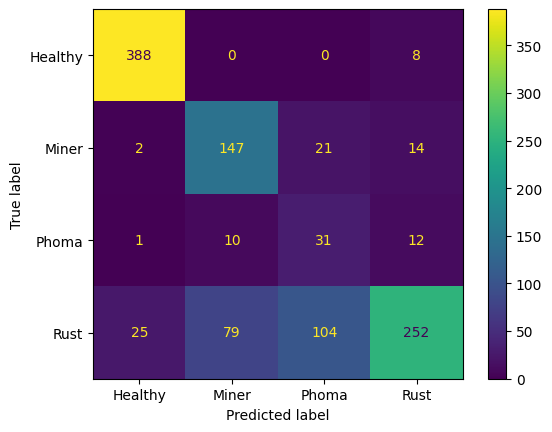

In [132]:
confusion_matrix = confusion_matrix(df_test['target'], df_test['predicted'])
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            #display_labels = ['Cescospora','Healthy','Miner','Phoma','Rust'])
                                            display_labels = ['Healthy','Miner','Phoma','Rust'])
                                            #display_labels = ['Miner','Phoma','Rust'])
cm_display.plot()
plt.show()

In [133]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, classification_report
metrics = evaluate_classification_multi(df_test['target'], df_test['predicted'])

              precision    recall  f1-score   support

     Healthy       0.93      0.98      0.96       396
       Miner       0.62      0.80      0.70       184
       Phoma       0.20      0.57      0.30        54
        Rust       0.88      0.55      0.68       460

    accuracy                           0.75      1094
   macro avg       0.66      0.73      0.66      1094
weighted avg       0.82      0.75      0.76      1094



In [134]:
metrics

{'Accuracy': 0.75,
 'F1 Score macro': 0.66,
 'Healthy Recall': 0.98,
 'Miner Recall': 0.8,
 'Phoma Recall': 0.57,
 'Rust Recall': 0.55,
 'Confusion Matrix': array([[388,   0,   0,   8],
        [  2, 147,  21,  14],
        [  1,  10,  31,  12],
        [ 25,  79, 104, 252]])}

In [ ]:
#model.save("/content/drive/MyDrive/SaoPauloChapter_Plants-Disease_2023-Aug-02/Task-4-Model(s) Building/models/withouth_cersc_and_healthy_resnet50_deduplicated_mix_val_train_67acc.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# MLFLOW saving experiment

Add your parameters for this experiment.

In [ ]:
strategy = 'fine tuned resnet 50 using strategy 002 dataset less Cesccospora and Healthy, class deduplicated, mixing df_val to train'
preprocess = 'resize 250x250, interpolation nearest, relu and softmax last layers, optmize adam'
split = 'already splited'
obs = 'using the test and val dataset provided from task 2, with no augmentation or preprocessing'
X = 'all images on strategy 2 dataset deduplicated, mixing df_val to train'
modelname = 'resnet 50 fine tuned'

loss = 'categorical_crossentropy'
metrics_optmizer = 'accuracy'
learning_rate=0.00001
train_batch = 128
val_batch = 512


In [ ]:
#don't need to change
dagshub.init("mlflow_free_omdena",your_dagshub_user, mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=346aa3d9-2193-406f-81dd-69973185e53c&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=930a396fe86394cb68b8dc3f1e664334f7916a16f65f3bb73f17ed16a40414c5




Repository initialized!

In [ ]:
#don't need to change
mlflow.set_tracking_uri('https://dagshub.com/lucasvascrocha/mlflow_free_omdena.mlflow')

In [ ]:
experiment_name = 'approach1'
mlflow_track(experiment_name, metrics,model,X,strategy,preprocess,split,obs,loss,metrics_optmizer,learning_rate,train_batch,val_batch)
